# Optimal Grid Search for Adapted Wasserstein Distance
 
This notebook runs experiments to determine the optimal grid for quantization of sample paths. For several sample sizes (from 500 to 5000) and for each grid size (from 0.01 to 0.5), we run 10 independent experiments. In each run we:
 
1. Generate paths using the provided lower‐triangular matrices (with T = 3).
2. For each nontrivial time step, we normalize the data, apply grid quantization (using the specified grid spacing), and then unnormalize the data.
3. Convert the quantized paths to indices (using a unique value mapping) and sort the paths.
4. Build the conditional distributions and compute the adapted Wasserstein squared distance.

We record both the computed distance and the elapsed computational time, and then plot the results (with ±1 standard deviation error bands) versus the grid size for each sample size.

_Note:_ This notebook assumes that the following functions are already available (via your modules):
- `Lmatrix2paths` (and its underlying normalization if desired)
- `adapted_wasserstein_squared`
- `sort_qpath`
- `qpath2mu_x`
- `list_repr_mu_x`
- `nested2_parallel`

The grid quantization is performed “time step by time step” as described.

In [1]:
import os, sys, numpy as np, time, warnings, random
import matplotlib.pyplot as plt

# Import your modules (make sure the path is set correctly)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from optimal_code.utils import *
from optimal_code.optimal_solver import *
from adapted_empirical_measure.AEM_grid import *

## Experiment Setup

We define:
- **Sample sizes:** from 500 to 5000 (in steps of 500)
- **Grid sizes:** a list of grid spacings (e.g. 0.01, 0.05, 0.1, ..., 0.5)
- **Number of runs:** 10 independent experiments per (sample size, grid size) pair.
 
We also set the time horizon T = 3 and define the matrices for the two processes.

In [ ]:
# Experiment parameters
sample_sizes = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
grid_sizes = [0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
n_runs = 2 # 10

T = 3  # number of time steps (excluding the trivial initial state)

# Define the matrices for the two processes.
L = np.array([[1, 0, 0],
              [2, 4, 0],
              [3, 2, 1]])
M = np.array([[1, 0, 0],
              [2, 3, 0],
              [3, 1, 2]])

## Helper Function: Quantize a Single Column

For each nontrivial time step we normalize the column (using min–max normalization), apply the grid quantization, and then unnormalize.

In [3]:
def quantize_column(col, grid_size):
    """
    Normalize a 1D array `col` (min-max normalization), apply grid quantization using the given grid_size,
    and then unnormalize back to the original scale.
    """
    min_val = col.min()
    max_val = col.max()
    if max_val - min_val > 0:
        norm_col = (col - min_val) / (max_val - min_val)
    else:
        norm_col = col.copy()
    # Apply grid quantization: round to nearest multiple of grid_size.
    quant_norm = np.floor(norm_col / grid_size + 0.5) * grid_size
    # Undo normalization:
    return quant_norm * (max_val - min_val) + min_val

## Main Experiment Loop
 
 For each sample size and for each grid size, we perform 10 runs. In every run we:
 
 1. Generate two sets of paths (for X and Y) using `Lmatrix2paths` (each run uses a new random seed).
 2. Compute the theoretical adapted Wasserstein squared distance (benchmark) using `adapted_wasserstein_squared`.
 3. For each nontrivial time step (i.e. time steps 1 to T), quantize the sample paths “column by column” using the current grid size.
 4. Map the resulting quantized values to indices, sort the paths, build the conditional distributions and compute the numerical adapted Wasserstein squared distance (using `nested2_parallel`).
 5. Record both the computed distance and the elapsed computation time.
 
 Results are stored in dictionaries keyed by sample size.

In [5]:
# Dictionary to store results for each sample size.
# For each sample size, we will store: 
#   - grid_sizes (list of grid spacings tested)
#   - distances: a 2D array (len(grid_sizes) x n_runs) of computed AW_2^2 values.
#   - times: a 2D array (len(grid_sizes) x n_runs) of computation times.
results = {}

for n_sample in sample_sizes:
    distances_per_grid = np.zeros((len(grid_sizes), n_runs))
    times_per_grid = np.zeros((len(grid_sizes), n_runs))
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    # For each grid size:
    for i, grid_size in enumerate(grid_sizes):
        # For each run:
        for run in range(n_runs):
            # Use a new random seed for each experiment
            random_seed = np.random.randint(10000)
            
            # Generate paths using Lmatrix2paths. 
            # (We use normalize=False since we handle normalization per time step below.)
            X, A = Lmatrix2paths(L, n_sample, seed=random_seed, verbose=False)
            Y, B = Lmatrix2paths(M, n_sample, seed=random_seed, verbose=False)
            
            # The theoretical benchmark distance (does not depend on the random sample paths)
            dist_bench = adapted_wasserstein_squared(A, B)
            
            # Transpose to have shape (n_sample, T+1) so that each row is a sample path.
            X = X.copy()  # shape: (n_sample, T+1)
            Y = Y.copy()  # shape: (n_sample, T+1)
            
            # Copy arrays to perform quantization (we leave the original X, Y intact if needed).
            qX = X.copy()
            qY = Y.copy()
            
            # For each nontrivial time step (skip the first column which is trivial, e.g., zeros)
            for t in range(1, T+1):
                qX[:, t] = quantize_column(X[:, t], grid_size)
                qY[:, t] = quantize_column(Y[:, t], grid_size)
            
            # Now, as in your original notebook, create the quantization mapping:
            combined = np.concatenate([qX, qY], axis=0)
            q2v = np.unique(combined)
            v2q = {val: idx for idx, val in enumerate(q2v)}
            
            # Convert each quantized path to an index sequence using the mapping.
            qX_indices = np.array([[v2q[x] for x in path] for path in qX])
            qY_indices = np.array([[v2q[x] for x in path] for path in qY])
            
            # Sort paths as in your procedure (note: sort_qpath expects data in a specific shape, here we transpose).
            qX_sorted = sort_qpath(qX_indices.T)
            qY_sorted = sort_qpath(qY_indices.T)
            
            # Get conditional distributions from the sorted quantized paths.
            mu_x = qpath2mu_x(qX_sorted)
            nu_y = qpath2mu_x(qY_sorted)
            
            # Get list representations (all lists except weights should be increasing).
            mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x(mu_x, q2v)
            nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x(nu_y, q2v)
            
            # Compute the numerical adapted Wasserstein squared distance.
            t_start = time.perf_counter()
            AW_2square = nested2_parallel(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                          nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                          n_processes=1)
            elapsed = time.perf_counter() - t_start
            
            # Record the computed distance and elapsed time.
            distances_per_grid[i, run] = AW_2square
            times_per_grid[i, run] = elapsed
            
            print(f"Sample size {n_sample}, grid {grid_size:.2f}, run {run+1}: AW2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    results[n_sample] = {"grid_sizes": grid_sizes,
                         "distances": distances_per_grid,
                         "times": times_per_grid,
                         "benchmark": dist_bench}  # benchmark is the same for all runs/sample sizes here.


Running experiments for sample size: 200


100%|██████████| 4/4 [00:00<00:00, 373.35it/s]


Sample size 200, grid 0.01, run 1: AW2^2 = 48.1203, Time = 40.7240 s


100%|██████████| 1/1 [00:00<00:00, 153.02it/s]


Sample size 200, grid 0.01, run 2: AW2^2 = 2.0735, Time = 46.3085 s


100%|██████████| 2/2 [00:00<00:00, 302.13it/s]


Sample size 200, grid 0.05, run 1: AW2^2 = 40.6711, Time = 38.4146 s


100%|██████████| 3/3 [00:00<00:00, 462.96it/s]


Sample size 200, grid 0.05, run 2: AW2^2 = 2.5827, Time = 39.0059 s


100%|██████████| 3/3 [00:00<00:00, 452.83it/s]


Sample size 200, grid 0.10, run 1: AW2^2 = 7.3627, Time = 38.9425 s


100%|██████████| 4/4 [00:00<00:00, 596.21it/s]


Sample size 200, grid 0.10, run 2: AW2^2 = 52.8601, Time = 39.0894 s


100%|██████████| 3/3 [00:00<00:00, 447.62it/s]


Sample size 200, grid 0.15, run 1: AW2^2 = 0.5241, Time = 38.3384 s


100%|██████████| 3/3 [00:00<00:00, 302.88it/s]


Sample size 200, grid 0.15, run 2: AW2^2 = 39.1938, Time = 38.1502 s


## Plotting Functions
 
 We now define functions to plot:
 
 1. The mean adapted Wasserstein squared distance (with ±1 standard deviation band) versus grid size.
 2. The mean computation time (with ±1 std band) versus grid size.
 
 These plots are generated for each sample size separately.

In [6]:
def plot_distance_vs_grid(grid_sizes, distances, benchmark, n_sample):
    """
    Plot the mean computed distance (with ± std band) vs. grid size for a given sample size.
    Also plots the benchmark as a horizontal dashed line.
    """
    distances_mean = distances.mean(axis=1)
    distances_std = distances.std(axis=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(grid_sizes, distances_mean, marker="o", label="Mean AW_2^2")
    plt.fill_between(grid_sizes, distances_mean - distances_std, distances_mean + distances_std, 
                     alpha=0.2, label="Std Dev")
    plt.axhline(y=benchmark, color="red", linestyle="--", label="Benchmark")
    plt.xlabel("Grid Size")
    plt.ylabel("Adapted Wasserstein Squared Distance")
    plt.title(f"Distance vs Grid Size (n_sample = {n_sample})")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_time_vs_grid(grid_sizes, times, n_sample):
    """
    Plot the mean computation time (with ± std band) vs. grid size for a given sample size.
    """
    times_mean = times.mean(axis=1)
    times_std = times.std(axis=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(grid_sizes, times_mean, marker="o", label="Mean Computation Time")
    plt.fill_between(grid_sizes, times_mean - times_std, times_mean + times_std, 
                     alpha=0.2, label="Std Dev")
    plt.xlabel("Grid Size")
    plt.ylabel("Computation Time (s)")
    plt.title(f"Computation Time vs Grid Size (n_sample = {n_sample})")
    plt.legend()
    plt.grid(True)
    plt.show()


## Plot Results for Each Sample Size

We now loop over our results dictionary and produce the two plots (distance and time vs grid size) for each sample size.

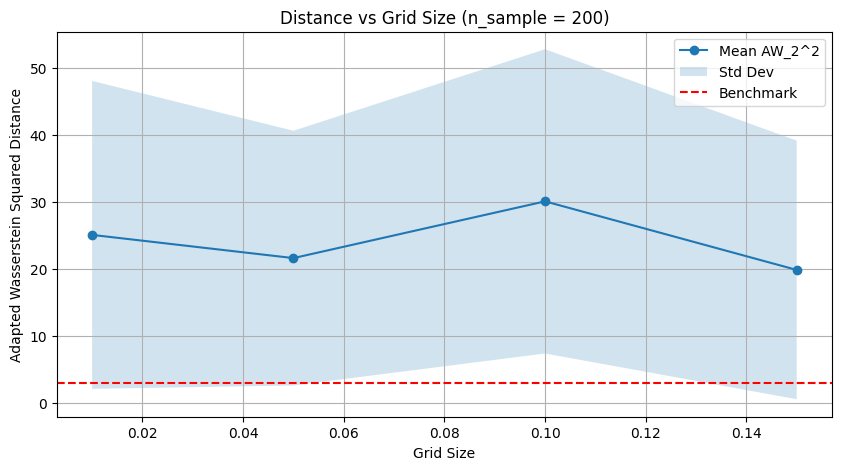

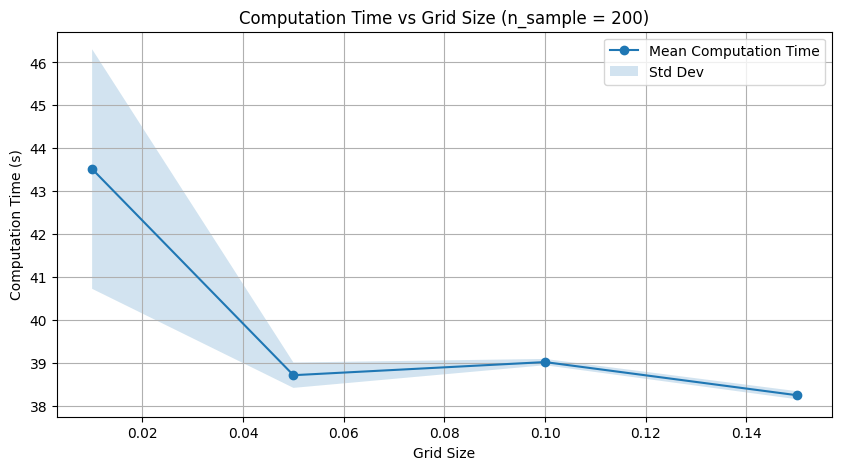

In [8]:
for n_sample, data in results.items():
    grid_list = data["grid_sizes"]
    dists = data["distances"]
    times = data["times"]
    benchmark = data["benchmark"]
    
    plot_distance_vs_grid(grid_list, dists, benchmark, n_sample)
    plot_time_vs_grid(grid_list, times, n_sample)